# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [37]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [38]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [39]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [40]:
## parsing data here
images, labels = parse_data(df)


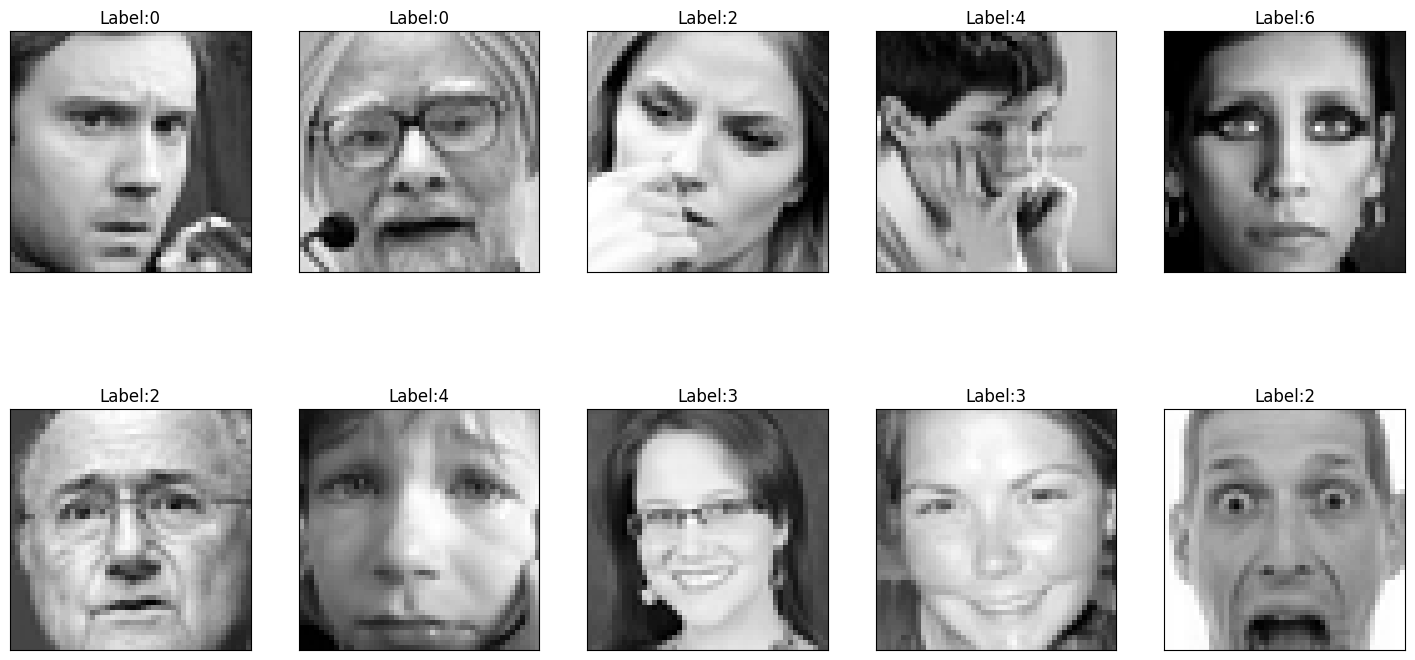

In [41]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [42]:
from sklearn.decomposition import PCA
# Reshape dữ liệu ảnh vào dạng (số lượng mẫu, số lượng features)
images_reshaped = images.reshape(images.shape[0], -1)

# Áp dụng PCA để giảm chiều dữ liệu xuống còn 2
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)
images_pca.shape

(35887, 2)

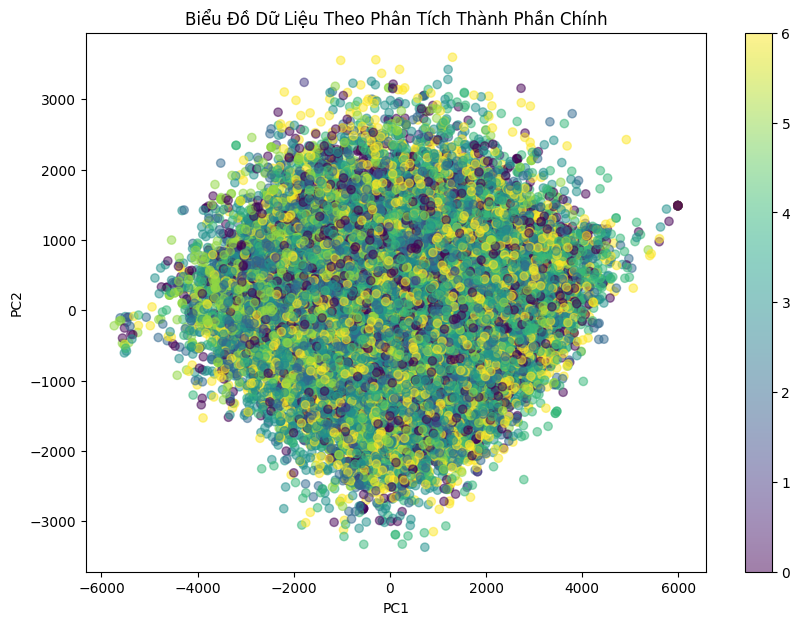

In [43]:
## transform for visualizing here
plt.figure(figsize=(10, 7))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Biểu Đồ Dữ Liệu Theo Phân Tích Thành Phần Chính')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Số lượng thành phần chính tối ưu để giữ lại 95.0% thông tin là: 255


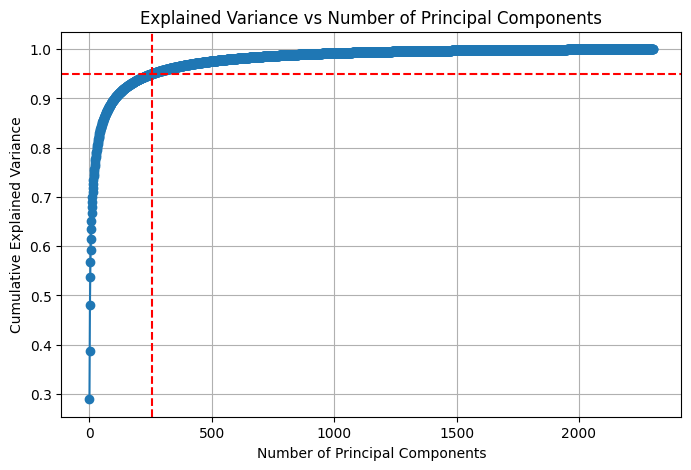

In [44]:
## determine the optimal number of PCs here
## pca.explained_variance_()
pca = PCA().fit(images_reshaped)  # Bạn cần phải có biến images_reshaped đã được prepare từ trước

# Tích lũy giải thích phương sai để xác định số lượng PCs
variance_explained_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Vẽ biểu đồ tích lũy giải thích phương sai để xác định PCs tối ưu
plt.figure(figsize=(8, 5))
plt.plot(variance_explained_cumulative, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)

# Đặt ngưỡng để chọn số lượng PC (ví dụ: 0.95 cho 95%)
threshold = 0.95
optimal_num_components = np.where(variance_explained_cumulative >= threshold)[0][0] + 1  # +1 vì index bắt đầu từ 0

print(f'Số lượng thành phần chính tối ưu để giữ lại {threshold*100}% thông tin là: {optimal_num_components}')

# Hiển thị biểu đồ
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=optimal_num_components, color='r', linestyle='--')
plt.show()



In [45]:
variance_explained_cumulative

array([0.2892651 , 0.387289  , 0.48154432, ..., 0.99999913, 0.99999958,
       1.        ])

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

ORIGINAL DATASET :

In [46]:
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [47]:
## splitting data into train/val/test subsets here
X = images_reshaped
y = df['emotion']

RANDOM_STATE = 12
TRAIN_SIZE = 0.7

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

SVM 

In [48]:
def build_SVCmodel(X, y, random_state=42):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svc", SVC(random_state=random_state)),
        ]
    )

    # Fit the pipeline on the training data
    pipeline.fit(X, y)

    return pipeline

# Example usage with training data (assuming X_train and y_train are defined)
pipeline = build_SVCmodel(X_train, y_train)

# Make predictions on the test data (assuming X_test is defined)
pred = pipeline.predict(X_test)

In [51]:
pred

array([4, 5, 3, ..., 3, 3, 4], dtype=int64)

In [52]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.45      0.24      0.32      1476
           1       0.90      0.05      0.10       176
           2       0.39      0.22      0.28      1519
           3       0.49      0.74      0.59      2688
           4       0.37      0.41      0.39      1872
           5       0.62      0.56      0.59      1155
           6       0.43      0.45      0.44      1881

    accuracy                           0.46     10767
   macro avg       0.52      0.38      0.39     10767
weighted avg       0.46      0.46      0.44     10767



In [53]:
print("Accuracy: ", accuracy_score(y_test, pred))
print("Precision: ", precision_score(y_test , pred, average = 'micro'))
print("Recall: ", recall_score(y_test , pred, average = 'micro'))
print("F1: ", f1_score(y_test , pred, average = 'micro'))

Accuracy:  0.4587164484071701
Precision:  0.4587164484071701
Recall:  0.4587164484071701
F1:  0.4587164484071701


In [49]:
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'svc__C': [0.1, 1, 10],
#     'svc__kernel': ['rbf', 'poly'],
#     'svc__gamma': ['scale', 'auto'],
# }

# # Initialize GridSearchCV with your pipeline and parameter grid
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# # Fit GridSearchCV on your training data
# grid_search.fit(X_train, y_train)

# # Retrieve the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Best Parameters:", best_params)
# print("Best Model:", best_model)

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [50]:
## visualize the confusion matrices and classification reports here